## **installing libraries**

In [ ]:
!pip install yfinance
!pip install darts
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

     |████████████████████████████████| 6.4 MB 7.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 322 kB 5.5 MB/s 
     |████████████████████████████████| 9.8 MB 48.1 MB/s 
     |████████████████████████████████| 11.2 MB 41.3 MB/s 
     |████████████████████████████████| 7

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 5.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requi

## **Importing libraries**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from darts.models import (
    LinearRegressionModel,
    ExponentialSmoothing,
    ARIMA, 
    RandomForest,
    Theta, 
    RegressionEnsembleModel, 
    NBEATSModel
)
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mse
# Feature Scaling
from sklearn.preprocessing import StandardScaler

## **Loading the Data**

In [ ]:
# Download additional stock data, which is correlated to Tesla stock, after research we found that NASDAQ is very correlated

tesla_df = yf.download(['TSLA'], 
                      start='2013-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()
nasdq_df = yf.download(['^IXIC'], 
                      start='2013-01-02', 
                      end='2021-06-30', 
                      progress=False).reset_index()

# Events is a self made data for the major events and its effect on tesla stock over the years
events = pd.read_excel('tesla_tweed_pre.xlsx', sheet_name='tesla_tweets')[['Date', 'accum_value']]
events = events[events['accum_value']!=0]
nasdq_df.columns = ['Date', 'NSDQ-Open', 'NSDQ-High', 'NSDQ-Low', 'NSDQ-Close', 'NSDQ-Adj Close', 'NSDQ-Volume']
tesla_df.columns = ['Date', 'tesla-Open', 'tesla-High', 'tesla-Low', 'tesla-Close', 'tesla-Adj Close', 'tesla-Volume']
event_tesla_merge = pd.merge(tesla_df, events, how='left', on='Date')
data = pd.merge(event_tesla_merge, nasdq_df, how='left', on='Date')
data['accum_value']=data['accum_value'].fillna(0)

# Data transformation
def date_extraction(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    # dataset['Year'] = pd.DatetimeIndex(dataset['Date']).year
    # dataset['Month'] = pd.DatetimeIndex(dataset['Date']).month
    # dataset['Day'] = dataset.Date.dt.day
    # dataset['DayOfWeek'] = dataset.Date.dt.dayofweek
    # dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    
    # dataset['Series'] = np.arange(1,len(data)+1)
date_extraction(data)
data.tail(2)

,Date,tesla-Open,tesla-High,tesla-Low,tesla-Close,tesla-Adj Close,tesla-Volume,accum_value,NSDQ-Open,NSDQ-High,NSDQ-Low,NSDQ-Close,NSDQ-Adj Close,NSDQ-Volume
2136,2021-06-28,671.640015,694.700012,670.320007,688.719971,688.719971,21628200,224.49,14417.80957,14505.190430,14417.200195,14500.509766,14500.509766,4235620000
2137,2021-06-29,684.650024,687.510010,675.890015,680.760010,680.760010,17381300,224.49,14509.19043,14535.969727,14471.379883,14528.330078,14528.330078,4842860000


In [ ]:
data = data.filter(['Date', 'tesla-Close', 'accum_value'], axis=1)
data = data.iloc[1500:].reset_index(drop=True).fillna(method='bfill')
full_dates = pd.DataFrame(pd.date_range(start = '2018-12-17', end = '2021-06-29', freq = 'D'), columns=['Date'])
data_fill = pd.merge(full_dates, data, how='left', on='Date').fillna(method='bfill')
data_fill.tail(2)


,Date,tesla-Close,accum_value
924,2021-06-28,688.719971,224.49
925,2021-06-29,680.760010,224.49


## **Plotting, selecting, and describing data**

In [ ]:
data_fill.corr()

,tesla-Close,accum_value
tesla-Close,1.000000,0.963774
accum_value,0.963774,1.000000


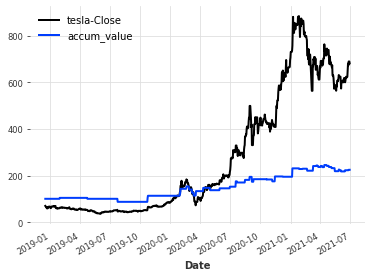

In [ ]:
data_merged = TimeSeries.from_dataframe(data_fill, time_col = 'Date', value_cols = ['accum_value','tesla-Close'],
                                    fill_missing_dates=True, freq='d')
col = ['tesla-Close', 'accum_value']
data_merged[col].plot()

## **Scalling and Training / Validation split**

In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

# Changing our data to timeseries product for the darts library
data_ts = TimeSeries.from_dataframe(data_fill, 
                                    time_col = 'Date', 
                                    value_cols = 'tesla-Close',
                                    fill_missing_dates=True, freq='d')
covariates = TimeSeries.from_dataframe(data_fill, 
                                    time_col = 'Date', 
                                    value_cols = 'accum_value',
                                    fill_missing_dates=True, freq='d')

scaler_target = Scaler()
data_ts_transformed = scaler_target.fit_transform(data_ts)
train_transformed, val_transformed = data_ts_transformed.split_before(pd.Timestamp('20210615'))

scaler_covariate = Scaler()
covariate_transformed = scaler_covariate.fit_transform(covariates)
past_cov, future_cov = covariate_transformed.split_before(pd.Timestamp('20210615')) 

# **Deep learning Models**

## **Temporal convolutional netword Models**

In [ ]:
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    input_chunk_length=100,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood())

deeptcn.fit(series=train_transformed, past_covariates=past_cov, verbose=True)



[2022-01-08 08:11:06,369] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 782 samples.
[2022-01-08 08:11:06,369] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 782 samples.
[2022-01-08 08:11:06,374] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-01-08 08:11:06,374] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-01-08 08:11:06,387] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 08:11:06,387] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

 55%|█████▌    | 11/20 [00:06<00:04,  1.81it/s]

100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


MAPE = 5.39%


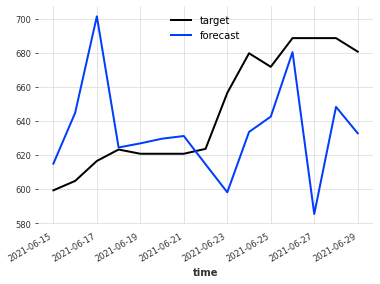

In [ ]:
pred = deeptcn.predict(15, past_covariates=past_cov, num_samples=1)
pred_orig = scaler_target.inverse_transform(pred)

val_orig = scaler_target.inverse_transform(val_transformed)
val_orig.slice_intersect(pred_orig).plot(label='target')

pred_orig.plot(label='forecast')
training = scaler_target.inverse_transform(train_transformed)
print('MAPE = {:.2f}%'.format(mape(pred_orig, val_orig)))

In [ ]:
pd.merge(pred_orig.pd_dataframe().rename(columns = {'tesla-Close':'Label'}), val_orig.pd_dataframe(), left_index=True, right_index=True).to_csv('TCN.csv')

### **Metrics**

In [ ]:
from darts.metrics import mape, mase, mae, rmse

mape_score = mape(val_orig, pred_orig)
mae_score = mae(val_orig, pred_orig)
rmse_score = rmse(val_orig, pred_orig)

print('TCN model MAPE is: {}%'.format(round(mape_score)))
print('TCN model MAE is: {}'.format(round(mae_score, 2)))
print('TCN model RMSE is: {}'.format(round(rmse_score)))


TCN model MAPE is: 5%
TCN model MAE is: 33.98
TCN model RMSE is: 45


In [ ]:
evaluation = pd.DataFrame({'TCN': [round((mape_score*100),2), round(mae_score, 2),round(rmse_score) ]}, index=['MAPE', 'MAE', 'RMSE'])
evaluation.to_csv('evaluation_TCN.csv')
evaluation

,TCN
MAPE,518.93
MAE,33.98
RMSE,45.00


## **NBEATS model**

In [ ]:
model = NBEATSModel(input_chunk_length=30, output_chunk_length=15, n_epochs=100, random_state=0)

model.fit([train_transformed, past_cov], verbose=True)



[2022-01-08 07:50:08,657] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1734 samples.
[2022-01-08 07:50:08,657] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1734 samples.
[2022-01-08 07:50:08,764] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-08 07:50:08,764] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:06<10:17,  6.23s/it]

 11%|█         | 11/100 [01:08<09:15,  6.25s/it]

 21%|██        | 21/100 [02:10<08:14,  6.26s/it]

 31%|███       | 31/100 [03:13<07:12,  6.27s/it]

 41%|████      | 41/100 [04:16<06:08,  6.25s/it]

 51%|█████     | 51/100 [05:18<05:07,  6.27s/it]

 61%|██████    | 61/100 [06:20<04:02,  6.22s/it]

 71%|███████   | 71/100 [07:23<03:01,  6.25s/it]

 81%|████████  | 81/100 [08:25<01:57,  6.20s/it]

 91%|█████████ | 91/100 [09:26<00:55,  6.12s/it]

100%|██████████| 100/100 [10:22<00:00,  6.23s/it]


### **Plotting**

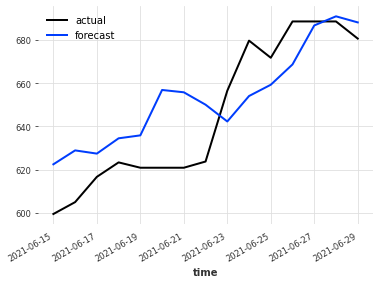

In [ ]:
pred = model.predict(n=15, series=train_transformed)
pred_orig = scaler_target.inverse_transform(pred)
val_orig = scaler_target.inverse_transform(val_transformed)

val_orig.plot(label='actual')
pred_orig.plot(label='forecast')

plt.legend();

In [ ]:
pd.merge(pred_orig.pd_dataframe().rename(columns = {'tesla-Close':'Label'}), val_orig.pd_dataframe(), left_index=True, right_index=True).to_csv('NBEATS.csv')

### **Metrics**

In [ ]:
mape_score = mape(val_orig, pred_orig)
mae_score = mae(val_orig, pred_orig)
rmse_score = rmse(val_orig, pred_orig)

print('NBEATS model MAPE is: {}%'.format(round(mape_score)))
print('NBEATS model MAE is: {}'.format(round(mae_score, 2)))
print('NBEATS model RMSE is: {}'.format(round(rmse_score)))

NBEATS model MAPE is: 3%
NBEATS model MAE is: 17.71
NBEATS model RMSE is: 20


In [ ]:
evaluation = pd.DataFrame({'NBEATS': [round((mape_score*100),2), round(mae_score, 2),round(rmse_score) ]}, index=['MAPE', 'MAE', 'RMSE'])
evaluation.to_csv('evaluation_NBEATS.csv')
evaluation

,NBEATS
MAPE,279.28
MAE,17.71
RMSE,20.00
